<a href="https://colab.research.google.com/github/jglombitza/deep-learning-physics/blob/main/Exercise_10_1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 10.1 - Solution
## Signal Classification using Dynamic Graph Convolutional Neural Networks
After a long journey through the universe before reaching the earth, the cosmic particles interact with the galactic magnetic field $B$.
As these particles carry a charge $q$ they are deflected in the field by the Lorentz force $F = q \cdot v × B$.
Sources of cosmic particles are located all over the sky, thus arrival distributions of the cosmic particles are isotropic in general. However, particles originating from the same source generate on top of the isotropic
arrival directions, street-like patterns from galactic magnetic field deflections.

In this tasks we want to classify whether a simulated set of $500$ arriving cosmic particles contains street-like patterns (signal), or originates from an isotropic background.

Training graph networks can be computationally demanding, thus, we recommend to use a GPU for this task.

In [1]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

layers = keras.layers


#### Download EdgeConv Layer

In [2]:
import gdown
import os

url = "https://raw.githubusercontent.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/main/edgeconv.py"
output = 'edgeconv.py'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=False)

from edgeconv import EdgeConv

Downloading...
From: https://raw.githubusercontent.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/main/edgeconv.py
To: /content/edgeconv.py
6.36kB [00:00, 13.5MB/s]                   


### Download Data

In [3]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1XKN-Ik7BDyMWdQ230zWS2bNxXL3_9jZq"
output = 'cr_sphere.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

In [4]:
f = np.load(output)
n_train = 10000
x_train, x_test = f['data'][:-n_train], f['data'][-n_train:]
labels = keras.utils.to_categorical(f['label'], num_classes=2)
y_train, y_test = labels[:-n_train], labels[-n_train:]

In [5]:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape (40000, 500, 4)
y_train.shape (40000, 2)


In [6]:
# define coordinates for very first EdgeConv
train_points, test_points = x_train[..., :3], x_test[..., :3]

# Use normalized Energy as features for convolutional layers
train_features, test_features = x_train[..., -1, np.newaxis], x_test[..., -1, np.newaxis]
train_features = np.concatenate([train_features, train_points], axis=-1)

train_input_data = [train_points, train_features]
test_input_data = [test_points, test_features]

### Plot an example sky map

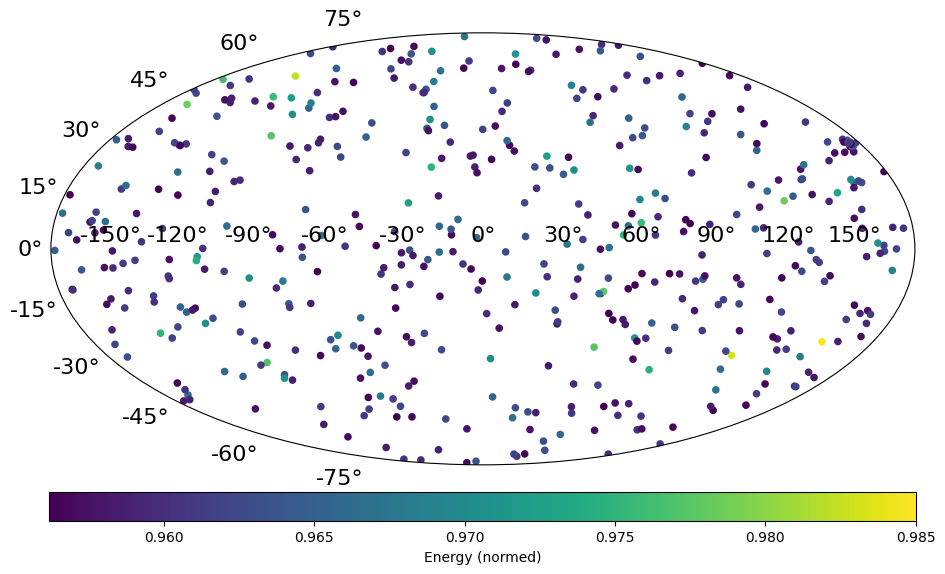

In [7]:
def scatter(v, c=None, zlabel="", title="", **kwargs):

    def vec2ang(v):
        x, y, z = np.asarray(v)
        phi = np.arctan2(y, x)
        theta = np.arctan2(z, (x * x + y * y) ** .5)
        return phi, theta

    lons, lats = vec2ang(v)
    lons = -lons
    fig = plt.figure(figsize=kwargs.pop('figsize', [12, 6]))
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.9], projection="hammer")
    events = ax.scatter(lons, lats, c=c, s=12, lw=2)

    cbar = plt.colorbar(events, orientation='horizontal', shrink=0.85, pad=0.05, aspect=30, label=zlabel)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return fig


test_id = 0
example_map = x_test[test_id]
fig = scatter(example_map[:, 0:3].T, c=example_map[:, 3], zlabel="Energy (normed)", title = "Event %i" % test_id)

### Design DGCNN

#### Start with defining a kernel network
Design a kernel network. The input to the kernel network is the central pixel coordinate and the neighborhood pixel coordinates.
Hint: using `layers.BatchNormalization` can help to stabilize the training process of a DGCNN.

You can make use of the code snippet below.

Note that the output of the DNN should be `(None, nodes)`, where `None` is a placeholder for the batch size.

<em> In this case, we perform subtraction and concatenate the result with the central pixel value to combine translational invariance with local information. </em>

In [8]:
def kernel_nn(data, nodes=16):
    d1, d2 = data  # get xi ("central" pixel) and xj ("neighborhood" pixels)

    dif = layers.Subtract()([d1, d2])  # perform substraction for translational invariance
    x = layers.Concatenate(axis=-1)([d1, dif])  # add information on the absolute pixel value

    x = layers.Dense(nodes, use_bias=False, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(nodes, use_bias=False, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(nodes, use_bias=False, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

#### Build complete graph network model
In the first layer, it might be advantageous to choose the next neighbors using the coordinates of the cosmic ray but perform the convolution using their energies also.
Thus, we input `y = EdgeConv(...)[points_input, feats_input]` into the first EdgeConv layer.  
If we later want to perform a dynamic EdgeConv (we want to update the graph), we simply input `z = EdgeConv(...)(y)`.

To specify the size of the "convolutional filter", make use of the `next_neighbors` argument (searches for $k$ next neighbors for each cosmic ray).

In [9]:
points_input = layers.Input((500, 3))
feats_input = layers.Input((500, 4))

x = EdgeConv(lambda a: kernel_nn(a, nodes=8), next_neighbors=8)([points_input, feats_input])  # conv with fixed graph
x = layers.Activation("relu")(x)
x = EdgeConv(lambda a: kernel_nn(a, nodes=16), next_neighbors=8)([points_input, x])  # conv with fixed graph
x = layers.Activation("relu")(x)
x = EdgeConv(lambda a: kernel_nn(a, nodes=32), next_neighbors=8)([x, x])  # conv with dynamic graph
x = layers.Activation("relu")(x)
x = layers.GlobalAveragePooling1D(name="embedding")(x)
out = layers.Dense(2, name="classification", activation="softmax")(x)

model = keras.models.Model([points_input, feats_input], out)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 3)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 500, 4)]             0         []                            
                                                                                                  
 edge_conv (EdgeConv)        (None, 500, 8)               288       ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 activation (Activation)     (None, 500, 8)               0         ['edge_conv[0][0]']       

You can inspect the kernel network using:

In [10]:
model.layers[2].kernel_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 reshape (Reshape)           (None, 2, 4)                 0         ['input_3[0][0]']             
                                                                                                  
 split_layer (SplitLayer)    [(None, 1, 4),               0         ['reshape[0][0]']             
                              (None, 1, 4)]                                                       
                                                                                                  
 reshape_1 (Reshape)         (None, 4)                    0         ['split_layer[0][0]']     

<em> The kernel network maps the energies an positions of 2 cosmic rays (the central and the neighbor comsic ray) to 8 features. </em>

The kernel network in the third layer maps from 16 extracted features (of 2 cosmic rays) to 32 new features and looks like this:

In [11]:
model.layers[6].kernel_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 2, 16)                0         ['input_5[0][0]']             
                                                                                                  
 split_layer (SplitLayer)    [(None, 1, 16),              0         ['reshape[0][0]']             
                              (None, 1, 16)]                                                      
                                                                                                  
 reshape_1 (Reshape)         (None, 16)                   0         ['split_layer[0][0]']     

### Train the model

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(3E-3, weight_decay=1E-4),
              metrics=['acc'])

If you don't have `networkx` or `sklearn` install it by executing:

In [13]:
history = model.fit(train_input_data, y_train, batch_size=64, epochs=4)

Epoch 1/4
625/625 [==============================] - 116s 167ms/step - loss: 0.2489 - acc: 0.9097
Epoch 2/4
625/625 [==============================] - 104s 167ms/step - loss: 0.0970 - acc: 0.9690
Epoch 3/4
625/625 [==============================] - 104s 167ms/step - loss: 0.0843 - acc: 0.9735
Epoch 4/4
625/625 [==============================] - 104s 167ms/step - loss: 0.0801 - acc: 0.9750


## Visualization of the underlying graph
To inspect the changing neighborhood relation (we used a dynamic layer) of the nodes, we visualize the underlying graph structure.

Note that plotting may take some time, so be a bit patient.

To perform the relative complex plotting, we make use of networkx and sklearn.  
If you don't have installed the packages yet, run the cell below.

In [14]:
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install networkx

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


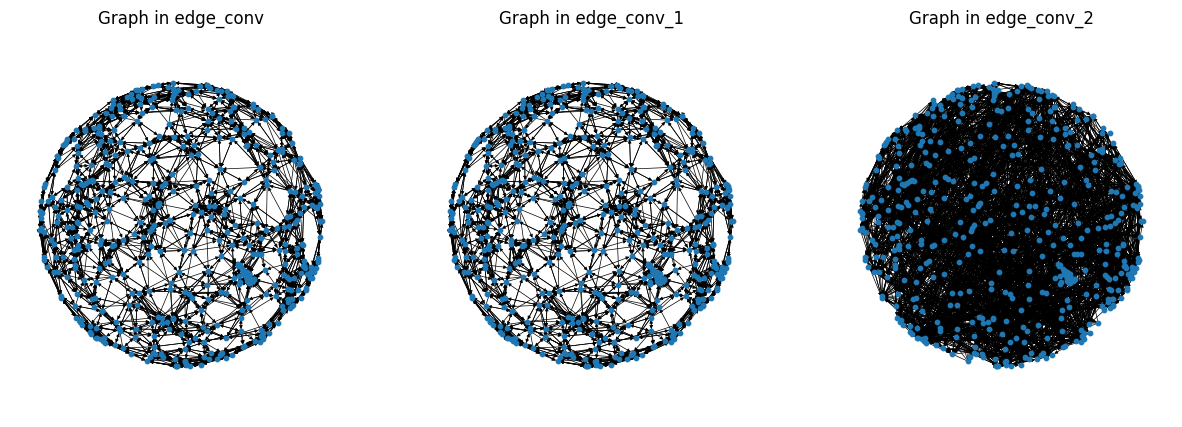

In [15]:
import tensorflow.keras.backend as K
from sklearn.neighbors import kneighbors_graph
import networkx as nx

edge_layers = [l for l in model.layers if "edge_conv" in l.name]
coord_mask = [np.sum(np.linalg.norm(inp_d[test_id], axis=-1)) == 500 for inp_d in train_input_data]
assert True in coord_mask, "For plotting the spherical graph at least one input has to have 3 dimensions XYZ"
fig, axes = plt.subplots(ncols=len(edge_layers), figsize=(5 * len(edge_layers), 5))

for i, e_layer in enumerate(edge_layers):
    points_in, feats_in = model.inputs
    coordinates = e_layer.get_input_at(0)
    functor = K.function(model.inputs, coordinates)
    sample_input = [inp[np.newaxis, test_id] for inp in train_input_data]

    if type(e_layer.input) == list:
        layer_points, layer_features = functor(sample_input)
    else:
        layer_points = functor(sample_input)

    layer_points = np.squeeze(layer_points)
    adj = kneighbors_graph(layer_points, e_layer.next_neighbors)
    g = nx.DiGraph(adj)

    for c, s in zip(coord_mask, sample_input):
        if c == True:
            pos = s
            break

    axes[i].set_title("Graph in %s" % e_layer.name)
    nx.draw(g, cmap=plt.get_cmap('viridis'), pos=pos.squeeze()[:, :-1],
            node_size=10, width=0.5, arrowsize=5, ax=axes[i])
    axes[i].axis('equal')